# Exercise 1a
#### Lars Kühmichel, Ergin Kohen Sagner, Nicolas Wolf

## 1 Monte-Carlo Simulation
### 1.1 Data Creation and Visualization
#### Inverse Transform Sampling
For $Y = 1$, it holds that $P(X = x) = 2x$. The CDF for $P$ is given as
$CDF(X \leq x) = \int_0^x 2x' \,dx' = x^2$.
With Inverse Transform Sampling, $X$ is then given by $CDF^{-1}(u) = \sqrt{u}$ where $u$ is
sampled from a uniform distribution in the interval $[0, 1]$.

For $Y = 0$, it holds that $P(x = x) = 2 - 2x$. The CDF for $P$ is then
$CDF(X \leq x) = \int_0^x 2 - 2x' \, dx' = 2x - x^2$. Analogously, $X$ is then given by $1 - \sqrt{1 - u}$.

In [15]:
import numpy as np
from typing import Tuple
from scipy.optimize import curve_fit
from uncertainties import ufloat
from matplotlib import pyplot as plt

<div style="color:green; font-weight: bold">
This solution is faster than the sample solution since it
initializes the full array with numpy (which is written in C) rather
than iterating over individual elements in python (which is slow).

This is also true for other parts of the code, but I will not mention it anymore.
</div>

In [16]:
def create_features(labels: np.ndarray) -> np.ndarray:
    features = np.random.uniform(0, 1, size=labels.shape)
    features = np.where(labels, np.sqrt(features), 1 - np.sqrt(1 - features))

    return features


def create_data(N: int) -> Tuple[np.ndarray, np.ndarray]:
    # randint is high exclusive
    labels = np.random.randint(0, 2, size=N).astype(bool)

    features = create_features(labels)

    return features, labels

<div style="color:green; font-weight: bold">
This code is effectively equivalent to the sample solution.
It is sufficient to only plot distribution histograms for X | Y = 0
and X | Y = 1, since implementing the uniform distribution for Y is trivial
and the cumulative distributions follow directly from the non-cumulative ones.
</div>

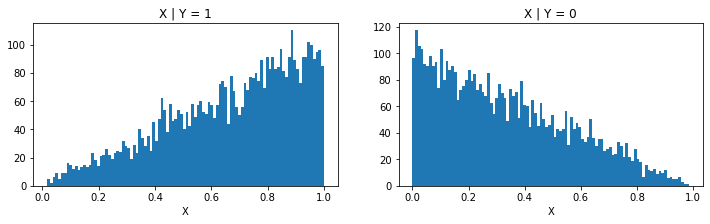

In [17]:
n = 10000

x, y = create_data(n)

# verify x and y are created correctly
fig, axes = plt.subplots(1, 2, figsize=(12, 3))
axes[0].hist(x[y], bins=100)
axes[0].set_title("X | Y = 1")
axes[0].set_xlabel("X")
axes[1].hist(x[~y], bins=100)
axes[1].set_title("X | Y = 0")
axes[1].set_xlabel("X")
plt.show()

### 1.2 Classification by Thresholding

We have experimentally confirmed the error rates, including the minimum at $x_t = 0.5$.
From the results, it can be presumed that the standard deviation in the error decreases with $\frac{1}{\sqrt{M}}$,
since multiplying $M$ by $10$ roughly divides the standard deviation by $3$.
This is further confirmed by the graphs we generated, including the fit and also coincides
with theoretical expectations of such.

<div style="color:green; font-weight: bold">
This code is equivalent to the sample solution.
I opted to write it as a class instead of a function for expandability.
</div>

In [18]:
class ClassifierTest:
    def __init__(self, data_creator, classifier):
        """
        Classifier Test Class
        :param data_creator: Callable that returns features and labels
        :param classifier: Callable that takes features and returns guesses for labels
        """
        self.data_creator = data_creator
        self.classifier = classifier

    def run(self, iterations, creator_args=None, creator_kwargs=None, classifier_args=None, classifier_kwargs=None):
        if creator_args is None:
	        creator_args = []
        if creator_kwargs is None:
	        creator_kwargs = {}
        if classifier_args is None:
            classifier_args = []
        if classifier_kwargs is None:
            classifier_kwargs = {}

        errors = []

        for _ in range(iterations):
            features, labels = self.data_creator(*creator_args, **creator_kwargs)

            classified = self.classifier(features, *classifier_args, **classifier_kwargs)

            incorrect = classified != labels

            error = np.mean(incorrect.astype(float))

            errors.append(error)

        return np.array(errors), np.mean(errors), np.std(errors)

<div style="color:green; font-weight: bold">
These classifier functions are slightly more elegant than the sample solution
since they do not require an if-statement, but are otherwise
nearly equivalent. The only difference is that these return
booleans instead of integers, but type conversion is trivial.
</div>

In [19]:
def tc(x, x_t):
    return x >= x_t

def tac(x, x_t):
    return x < x_t

def std_fit_func(M, a):
    return a / np.sqrt(M)

def r_sq(data, fit):
    """
    R^2 Goodness of Fit Test
    Good fits return values close to 1.
    See also: https://en.wikipedia.org/wiki/Coefficient_of_determination
    """
    ss_res = np.sum((data - fit) ** 2)
    ss_tot = np.sum((data - np.mean(data)) ** 2)

    return 1 - (ss_res / ss_tot)

x_ts = [0.2, 0.5, 0.6]
Ms = [10, 100, 1000, 10_000]

<div style="color:green; font-weight: bold">
We print the data instead of using Pandas for a DataFrame,
which makes it slightly harder to get a good overview of the data,
but is otherwise equivalent.
Our plots are equivalent to the sample solution's, except for some formatting.
We did not plot the error rate mean, since we confirmed its minimal value numerically only.
</div>

x_t = 0.2
M = 10
Expected Error TC = 0.34
Actual Error TC = 0.40+/-0.19
Expected Error TAC = 0.66
Actual Error TAC = 0.62+/-0.18

M = 100
Expected Error TC = 0.34
Actual Error TC = 0.33+/-0.04
Expected Error TAC = 0.66
Actual Error TAC = 0.666+/-0.031

M = 1000
Expected Error TC = 0.34
Actual Error TC = 0.340+/-0.011
Expected Error TAC = 0.66
Actual Error TAC = 0.665+/-0.012

M = 10000
Expected Error TC = 0.34
Actual Error TC = 0.3408+/-0.0034
Expected Error TAC = 0.66
Actual Error TAC = 0.6612+/-0.0025

x_t = 0.5
M = 10
Expected Error TC = 0.25
Actual Error TC = 0.21+/-0.12
Expected Error TAC = 0.75
Actual Error TAC = 0.78+/-0.10

M = 100
Expected Error TC = 0.25
Actual Error TC = 0.228+/-0.032
Expected Error TAC = 0.75
Actual Error TAC = 0.74+/-0.05

M = 1000
Expected Error TC = 0.25
Actual Error TC = 0.242+/-0.013
Expected Error TAC = 0.75
Actual Error TAC = 0.754+/-0.011

M = 10000
Expected Error TC = 0.25
Actual Error TC = 0.250+/-0.005
Expected Error TAC = 0.75
Actual Error TAC =

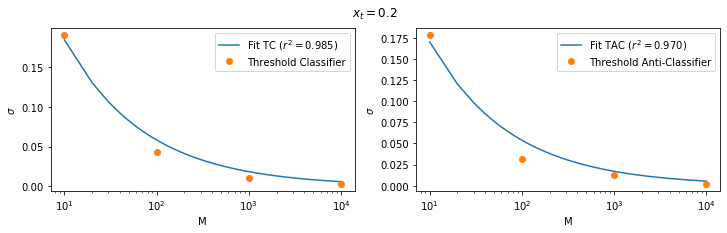

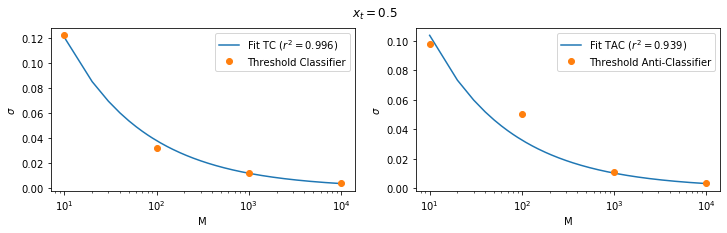

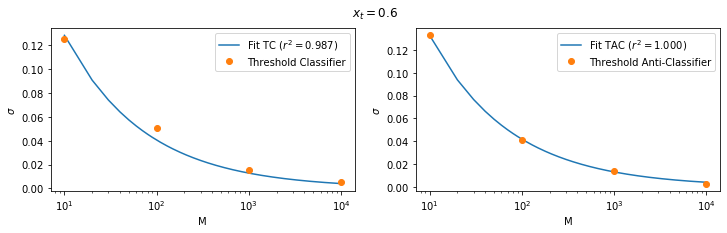

In [20]:
for x_t in x_ts:
    print("=========================")
    print(f"x_t = {x_t}")
    print("=========================")

    stds_tc = []
    stds_tac = []
    for M in Ms:
        predicted_error_tc = 0.25 + (x_t - 0.5) ** 2
        predicted_error_tac = 1 - predicted_error_tc

        tc_test = ClassifierTest(create_data, tc)
        tac_test = ClassifierTest(create_data, tac)

        errors_tc, mean_tc, std_tc = tc_test.run(
            iterations=10,
            creator_args=[M],
            creator_kwargs=None,
            classifier_args=[x_t],
            classifier_kwargs=None
        )

        errors_tac, mean_tac, std_tac = tac_test.run(
            iterations=10,
            creator_args=[M],
            creator_kwargs=None,
            classifier_args=[x_t],
            classifier_kwargs=None
        )

        stds_tc.append(std_tc)
        stds_tac.append(std_tac)

        # pretty printing
        print(f"M = {M}")
        print(f"Expected Error TC = {predicted_error_tc:.2f}")
        print(f"Actual Error TC = {ufloat(mean_tc, std_tc)}")
        print(f"Expected Error TAC = {predicted_error_tac}")
        print(f"Actual Error TAC = {ufloat(mean_tac, std_tac)}")
        print()

    popt_tc, pcov_tc = curve_fit(std_fit_func, Ms, stds_tc)
    popt_tac, pcov_tac = curve_fit(std_fit_func, Ms, stds_tac)

    fig, axes = plt.subplots(1, 2, figsize=(12, 3))

    r2_tc = r_sq(stds_tc, std_fit_func(Ms, *popt_tc))
    r2_tac = r_sq(stds_tac, std_fit_func(Ms, *popt_tac))

    plot_x = np.linspace(min(Ms), max(Ms), 1000)
    axes[0].plot(plot_x, std_fit_func(plot_x, *popt_tc), label=f"Fit TC $(r^2 = {r2_tc:.3f})$")
    axes[1].plot(plot_x, std_fit_func(plot_x, *popt_tac), label=f"Fit TAC $(r^2 = {r2_tac:.3f})$")

    del plot_x

    axes[0].plot(Ms, stds_tc, lw=0, marker="o", label="Threshold Classifier")
    axes[1].plot(Ms, stds_tac, lw=0, marker="o", label="Threshold Anti-Classifier")

    fig.suptitle(f"$x_t = {x_t}$")
    for ax in axes:
        ax.set_xlabel("M")
        ax.set_ylabel(r"$\sigma$")
        ax.set_xscale("log")
        ax.legend()
    plt.show()



### 1.3 Baseline Classifiers

We can confirm the expected error rate of $50\%$.

<div style="color:green; font-weight: bold">
These classifiers are equivalent to the sample solution
</div>

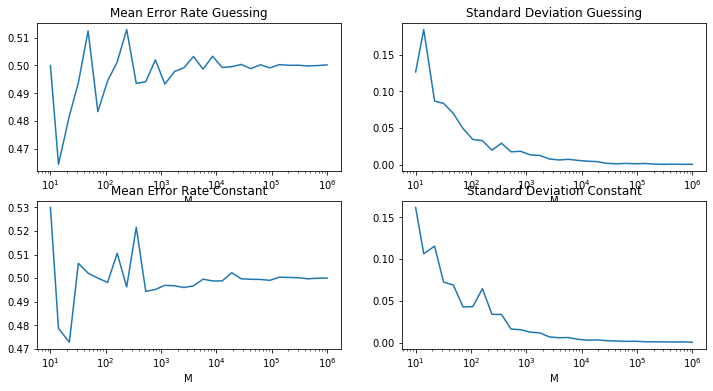

In [21]:
def guessing(x):
    return np.random.choice([True, False], size=x.shape)

def constant(x):
    return np.ones_like(x).astype(bool)

Ms = np.logspace(1, 6, 30, dtype=int)
means_g = []
stds_g = []
means_c = []
stds_c = []

for M in Ms:
    guessing_test = ClassifierTest(create_data, guessing)
    constant_test = ClassifierTest(create_data, constant)

    errors_g, mean_g, std_g = guessing_test.run(
        iterations=10,
        creator_args=[M],
        creator_kwargs=None,
        classifier_args=None,
        classifier_kwargs=None
    )

    errors_c, mean_c, std_c = constant_test.run(
        iterations=10,
        creator_args=[M],
        creator_kwargs=None,
        classifier_args=None,
        classifier_kwargs=None
    )

    # print(f"M = {M}")
    # print(f"Error Guessing = {ufloat(mean_g, std_g)}")
    # print(f"Error Constant = {ufloat(mean_c, std_c)}")

    means_g.append(mean_g)
    stds_g.append(std_g)

    means_c.append(mean_c)
    stds_c.append(std_c)

<div style="color:green; font-weight: bold">
Again, plots are equivalent to the sample solution. Sway in the mean error rate looks a
little more exaggerated here since we do not plot error bars.
</div>

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(12, 6))
axes[0][0].plot(Ms, means_g)
axes[0][0].set_title("Mean Error Rate Guessing")
axes[0][0].set_xscale("log")
axes[0][1].plot(Ms, stds_g)
axes[0][1].set_title("Standard Deviation Guessing")
axes[0][1].set_xscale("log")
axes[1][0].plot(Ms, means_c)
axes[1][0].set_title("Mean Error Rate Constant")
axes[1][0].set_xscale("log")
axes[1][1].plot(Ms, stds_c)
axes[1][1].set_title("Standard Deviation Constant")
axes[1][1].set_xscale("log")

for row in axes:
    for ax in row:
        ax.set_xlabel("M")

plt.show()



### 1.4 Nearest Neighbor Classification

Error: 0.33+/-0.15
Error: 0.333+/-0.028


<div style="color:green; font-weight: bold">
Again, I opted for a class instead of a callable here for expandability.
It is more elegant to use a custom distance function as seen in this solution,
but the sample solution provides a more elegant way of finding the argmin using np.argmin.
Otherwise, these solutions are both equivalent.
</div>

In [ ]:
class NearestNeighborClassifier:
    @staticmethod
    def euclid(x1, x2):
        return abs(x1 - x2)

    _euclid = euclid.__func__

    def __init__(self, training_set, distance_function=_euclid):
        self.training_set = training_set
        self.distance = distance_function

    def assign(self, feature):
        min_dist = None
        label = None
        for tfeature, tlabel in self.training_set.items():
            dist = self.distance(tfeature, feature)
            if min_dist is None or min_dist > dist:
                min_dist = dist
                label = tlabel

        return label


M = 100
training_y = np.array([0, 1])

errors = []

<div style="color:green; font-weight: bold">
Using a function (as seen here) instead of assigning features manually
(as seen in the sample solution) is better to avoid copied code.
</div>

In [ ]:
for _ in range(M):
    # create training set
    training_x = create_features(training_y)
    training_set = dict(zip(training_x, training_y))

    # create classifier with that set
    nnc = NearestNeighborClassifier(training_set)

    # now test the classifier
    test_size = 1000
    test_features, test_labels = create_data(test_size)

    classified = np.array([nnc.assign(tf) for tf in test_features])
    incorrect = classified != test_labels

    error = np.mean(incorrect.astype(float))

    errors.append(error)

mean_error, std_error = np.mean(errors), np.std(errors)

print(f"Error: {ufloat(mean_error, std_error)}")

N = 100
errors = []

<div style="color:green; font-weight: bold">
For sufficient training set size, this method is equivalent to the sample solution.
However, the sample solution is more elegant
since it will always generate a balanced training set,
whereas this solution may yield slightly imbalanced training sets.
</div>

In [ ]:
for _ in range(M):
    # create training set
    training_x, training_y = create_data(N)
    training_set = dict(zip(training_x, training_y))

    # create classifier with that set
    nnc = NearestNeighborClassifier(training_set)

    # now test the classifier
    test_size = 1000
    test_features, test_labels = create_data(test_size)

    classified = np.array([nnc.assign(tf) for tf in test_features])
    incorrect = classified != test_labels

    error = np.mean(incorrect.astype(float))

    errors.append(error)

mean_error, std_error = np.mean(errors), np.std(errors)

print(f"Error: {ufloat(mean_error, std_error)}")